# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [223]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [224]:
df = pd.read_csv('/content/drive/MyDrive/previsao_de_renda.csv')

df.head()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [226]:
# Eliminando linhas com missing values

df.dropna(axis=0, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             12427 non-null  int64  
 1   data_ref               12427 non-null  object 
 2   id_cliente             12427 non-null  int64  
 3   sexo                   12427 non-null  object 
 4   posse_de_veiculo       12427 non-null  bool   
 5   posse_de_imovel        12427 non-null  bool   
 6   qtd_filhos             12427 non-null  int64  
 7   tipo_renda             12427 non-null  object 
 8   educacao               12427 non-null  object 
 9   estado_civil           12427 non-null  object 
 10  tipo_residencia        12427 non-null  object 
 11  idade                  12427 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  12427 non-null  float64
 14  renda                  12427 non-null  float64
dtypes:

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

***1 - Separe a base em treinamento e teste (25% para teste, 75% para treinamento).***

In [227]:
# Separando 75% da base treinamento e 25% para teste

treino, teste = train_test_split(df, train_size=0.75, random_state=2360873)

***2 - Rode uma regularização ridge com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o  R2  na base de testes. Qual o melhor modelo?***

In [228]:
# Criando modelo de regressão linear múltipla na base treino

modelo = 'renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'

md = smf.ols(modelo, data=treino)

In [229]:
# Rodando modelo com regularização "ridge" com alpha 0, 0.001, 0.005, 0.01, 0.05 e 0.1

lista_alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

score_ridge = []

for i in lista_alpha:

  reg = md.fit_regularized(method='elastic_net',
                         refit=True,
                         L1_wt=0,
                         alpha=i)

  score = r2_score(teste['renda'], reg.predict(teste))

  score_ridge.append(score)

dados = pd.DataFrame(score_ridge, columns=['ridge'], index=lista_alpha)

dados

,ridge
0.000,0.270372
0.001,0.271345
0.005,0.272047
0.010,0.272526
0.050,0.271563
0.100,0.266168


*O modelo com alpha 0.01 chega ao melhor resultado*

***3 - Faça o mesmo que no passo 2, com uma regressão LASSO. Qual método chega a um melhor resultado?***

In [230]:
# Rodando modelo com regularização "lasso" com alpha 0, 0.001, 0.005, 0.01, 0.05 e 0.1

score_lasso = []

for i in lista_alpha:

  reg = md.fit_regularized(method='elastic_net',
                         refit=True,
                         L1_wt=1,
                         alpha=i)

  score = r2_score(teste['renda'], reg.predict(teste))

  score_lasso.append(score)

dados['lasso'] = score_lasso

dados

,ridge,lasso
0.000,0.270372,0.270372
0.001,0.271345,0.270372
0.005,0.272047,0.270356
0.010,0.272526,0.270372
0.050,0.271563,0.270372
0.100,0.266168,0.270356


*O modelo com regularização "ridge" com alpha 0.01 chega ao melhor resultado*

***4 - Rode um modelo stepwise. Avalie o  R2  na base de testes. Qual o melhor resultado?***

In [231]:
# criando a função de seleção de variáveis explicativas pelo método stepwise

def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.05,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=np.dtype('float64'))
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.index[new_pval.argmin()]
            included.append(best_feature)
            changed=True
            if verbose:
                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        print("#############")
        print(included)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included



In [232]:
# adequando a base de dados para a função stepwise

# transformando as variáveis explicativas em tipo dummy e renomeando colunas

X = treino[['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']]
treino_dummy = pd.get_dummies(X)
treino_dummy.rename(columns = {'educacao_Superior completo' : 'educacao_Superior_completo'}, inplace=True)
x_treino = treino_dummy.drop('renda', axis=1)

X = teste[['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']]
teste_dummy = pd.get_dummies(X)
teste_dummy.rename(columns = {'educacao_Superior completo' : 'educacao_Superior_completo'}, inplace=True)
x_teste = teste_dummy.drop('renda', axis=1)

# transformando dados do tipo bool em int

x_treino['posse_de_veiculo'] = treino['posse_de_veiculo'].apply(int)
x_treino['posse_de_imovel'] = treino['posse_de_imovel'].apply(int)
x_teste['posse_de_veiculo'] = teste['posse_de_veiculo'].apply(int)
x_teste['posse_de_imovel'] = teste['posse_de_imovel'].apply(int)



In [233]:
# executando a função stepwise

variaveis = stepwise_selection(x_treino, treino_dummy['renda'])

print('resulting features:')
print(variaveis)

Add  tempo_emprego                  with p-value 0.0
#############
['tempo_emprego']
Add  sexo_M                         with p-value 1.28049e-256
#############
['tempo_emprego', 'sexo_M']
Add  sexo_F                         with p-value 4.40213e-123
#############
['tempo_emprego', 'sexo_M', 'sexo_F']
Add  idade                          with p-value 4.36743e-06
#############
['tempo_emprego', 'sexo_M', 'sexo_F', 'idade']
Add  tipo_renda_Empresário          with p-value 1.35509e-05
#############
['tempo_emprego', 'sexo_M', 'sexo_F', 'idade', 'tipo_renda_Empresário']
Add  educacao_Superior_completo     with p-value 0.00156882
#############
['tempo_emprego', 'sexo_M', 'sexo_F', 'idade', 'tipo_renda_Empresário', 'educacao_Superior_completo']
Add  estado_civil_Casado            with p-value 0.0210294
#############
['tempo_emprego', 'sexo_M', 'sexo_F', 'idade', 'tipo_renda_Empresário', 'educacao_Superior_completo', 'estado_civil_Casado']
#############
['tempo_emprego', 'sexo_M', 'sexo_F', 'i

In [234]:
# criando modelo a partir das variáveis selecionadas pelo método stepwise

y, X = patsy.dmatrices('renda ~ tempo_emprego + sexo_M + sexo_F + tipo_renda_Empresário + idade + educacao_Superior_completo + estado_civil_Casado + posse_de_imovel', treino_dummy )

reg = sm.OLS(y,X).fit()

# apurando o R² do modelo

reg.rsquared


0.25126908699245254

*O modelo com regularização "ridge" com alpha 0.01 ainda apresenta melhor resultado*

***5 - Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?***

*O modelo "ridge" com alpha 0.01 apresenta-se melhor de todos*

***6 - Partindo dos modelos que você ajustou, tente melhorar o  R2  na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.***

In [235]:
# rodando o modelo ridge com alpha 0.01 na base de treino

modelo = 'renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'

md = smf.ols(modelo, data=treino)

reg = md.fit_regularized(method='elastic_net',
                         refit=True,
                         L1_wt=0,
                         alpha=0.01)

r2_score(treino['renda'], reg.predict())

0.25134695370143256

In [236]:
# rodando modelo para verificar as variáveis não significantes

modelo = 'renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'

y, X = patsy.dmatrices(modelo, treino)

reg = sm.OLS(y,X).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  renda   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     130.6
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        03:35:19   Log-Likelihood:                -96928.
No. Observations:                9320   AIC:                         1.939e+05
Df Residuals:                    9295   BIC:                         1.941e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                        -7923.1758   2889.816     -2.742      0.006   -1.36e+04   -2258.504
sexo[T.M]                         6230.3670    186.540     33.400      0.000    5864.707    6596.027
posse_de_veiculo[T.True]            22.0358    180.121      0.122      0.903    -331.041     375.113
posse_de_imovel[T.True]            340.9355    178.092      1.914      0.056      -8.163     690.034
tipo_renda[T.Bolsista]           -1897.4447   3986.931     -0.476      0.634   -9712.703    5917.813
tipo_renda[T.Empresário]           793.0649    190.663      4.160      0.000     419.323    1166.807
tipo_renda[T.Pensionista]        -2354.5081   3017.098     -0.780      0.435   -8268.681    3559.665
tipo_renda[T.Servidor público]      77.2736    282.290      0.274      0.784    -476.076     630.624
educacao[T.Pós graduação]         1372.0400   1935.268      0.709      0.478   -2421.509    5165.589
educacao[T.Secundário]            1018.4406    925.457      1.100      0.271    -795.657    2832.539
educacao[T.Superior completo]     1503.5760    928.464      1.619      0.105    -316.417    3323.570
educacao[T.Superior incompleto]    447.6591    997.107      0.449      0.653   -1506.890    2402.208
estado_civil[T.Separado]          2044.3367   1357.334      1.506      0.132    -616.336    4705.010
estado_civil[T.Solteiro]          1650.6720   1329.956      1.241      0.215    -956.332    4257.677
estado_civil[T.União]             -382.5607    321.253     -1.191      0.234   -1012.288     247.167
estado_civil[T.Viúvo]             1761.4099   1419.982      1.240      0.215   -1022.067    4544.886
tipo_residencia[T.Casa]           -245.0252    692.967     -0.354      0.724   -1603.393    1113.342
tipo_residencia[T.Com os pais]    -273.7519    771.537     -0.355      0.723   -1786.134    1238.630
tipo_residencia[T.Comunitário]    -459.5014   1271.099     -0.361      0.718   -2951.135    2032.132
tipo_residencia[T.Estúdio]         503.4030   1284.350      0.392      0.695   -2014.205    3021.011
tipo_residencia[T.Governamental]   438.4844    849.692      0.516      0.606   -1227.097    2104.066
qtd_filhos                       -2084.9360   1312.989     -1.588      0.112   -4658.681     488.809
idade                               43.1429     10.225      4.219      0.000      23.100      63.186
tempo_emprego                      567.0530     13.243     42.818      0.000     541.093     593.013
qt_pessoas_residencia             2171.9889   1311.193      1.656      0.098    -398.238    4742.215
==============================================================================
Omnibus:                    13603.862   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8559499.633
Skew:             

In [237]:
# rodando modelo ridge somente com as variáveis explicativas

modelo = 'renda ~ sexo + posse_de_imovel + idade + tempo_emprego'

md = smf.ols(modelo, data=treino)

reg = md.fit_regularized(method='elastic_net',
                         refit=True,
                         L1_wt=0,
                         alpha=0.01)

r2_score(treino['renda'], reg.predict())

0.24822527007441297

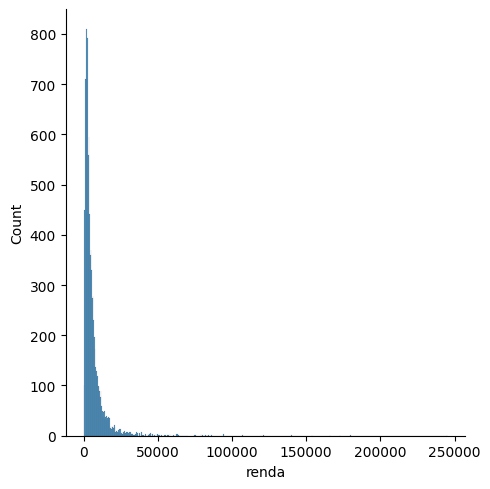

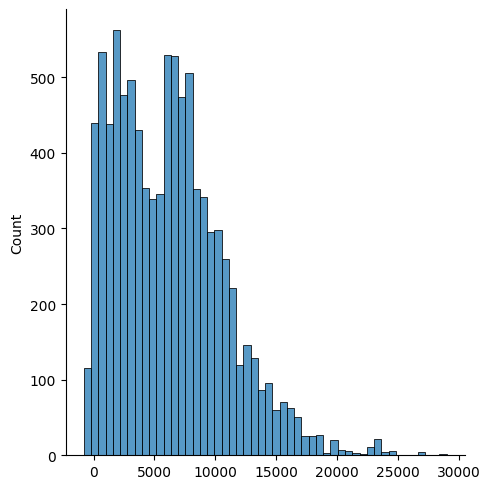

In [238]:
# analisando a distribuição da variável dependente "renda" e das previsões do modelo ridge com alpha 0.01 na base de treino

sns.displot(treino['renda'])
sns.displot(reg.predict())

*Observa-se que a distribuição dos valores preditos é bastante diferente dos valores da variável "renda". Parece interessante experimentar novos modelos transformando os valores da nossa variável alvo*

In [239]:
# rodando o modelo ridge com alpha 0.01 na base de treino, explicando o logarítmo dos valores de "renda"

# criando coluna com valores do logarítmos de renda

treino['renda_log'] = np.log(treino['renda'])

# rodando modelo ridge com variáveis explicativas significativas para explicar o logarítmo dos valores de renda

modelo = 'np.log(renda) ~ sexo + posse_de_imovel + idade + tempo_emprego'

md = smf.ols(modelo, data=treino)

reg = md.fit_regularized(method='elastic_net',
                         refit=True,
                         L1_wt=0,
                         alpha=0.01)

r2_score(treino['renda_log'], reg.predict())

0.2524764864645317

*Aparentemente houve melhoria na performance do modelo. Será tentado outro método na criação de modelo*

In [240]:
modelo = 'np.log(renda) ~ sexo + posse_de_imovel + idade + tempo_emprego'

y, X = patsy.dmatrices(modelo, treino)

reg = sm.OLS(y,X).fit()

r2_score(treino['renda_log'], reg.predict())


0.34671026967723706

*A julgar pelo coeficiente de determinação, nota-se que houve um salto de performance de R² 0.252 para R² 0.346*